In [83]:
import os
import tqdm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import pytorch_lightning  as pl

import numpy as np

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
import statsmodels as sm
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.api import qqplot

In [2]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    print(attn_logits.shape, v.shape)
    values = torch.matmul(attention, v)
    return values, attention

In [19]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)
print("Attention\n", attention.shape)

Global seed set to 42


torch.Size([3, 3]) torch.Size([3, 2])
Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])
Attention
 torch.Size([3, 3])


In [3]:
root = 'D:/option/master/diff/15S_15T'
save_root = 'D:/option/master/diff/15S_15T_y'

In [4]:
%matplotlib inline

In [5]:
for f in os.listdir(root):
    store = pd.HDFStore(os.path.join(root, f), 'r')
    y = store['y']
    store.close()
    
    sn.displot(y, kde=True)
    plt.savefig(os.path.join(save_root, '%s.png' % f))
    plt.close()
    print(f)
    break

SHFE.rb.2021-04-06.15S.15T.20703.h5


In [6]:
# %matplotlib qt

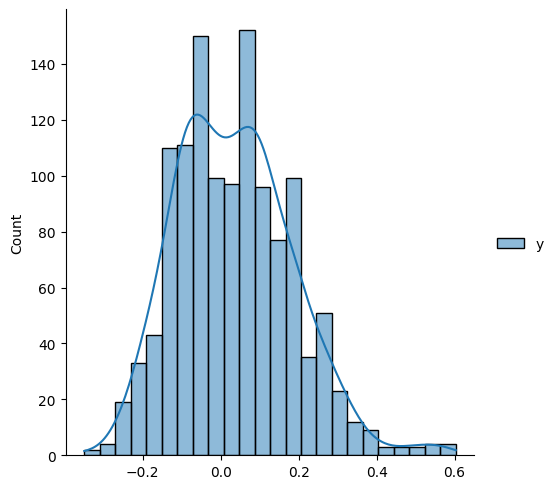

In [7]:
sn.displot(y, kde=True)
plt.savefig('D:/option/master/diff/15S_15T_y/save_as_a_png.png')

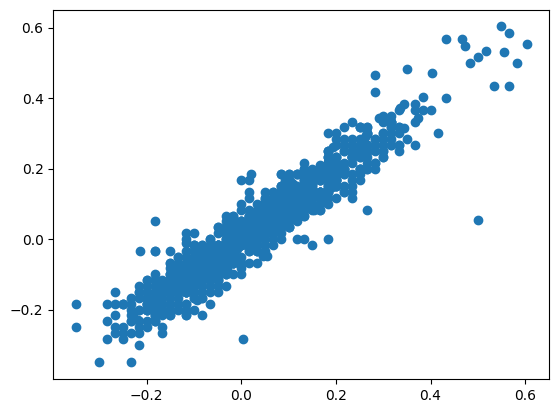

In [8]:
plt.scatter(y, y.shift(1))

In [9]:
stattools.acovf(y)

array([ 2.24836885e-02,  2.12409948e-02,  2.00963626e-02, ...,
       -1.00008602e-04, -6.20185769e-05, -2.70005326e-05])

In [10]:
%matplotlib inline

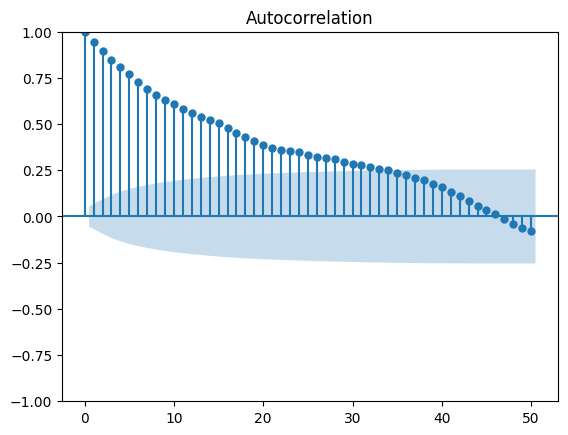

In [11]:
ax = tsaplots.plot_acf(y, lags=50)

D:\Software\Python\torch\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


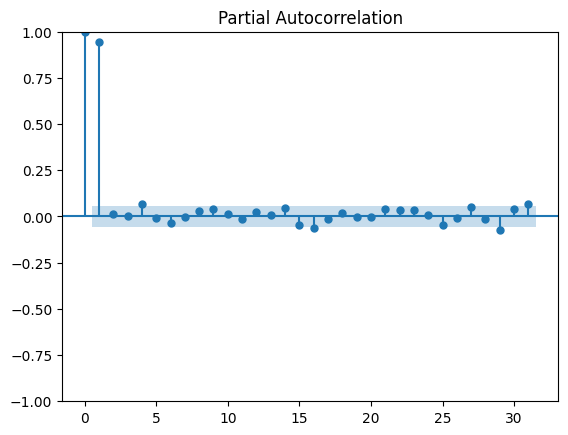

In [12]:
ax = tsaplots.plot_pacf(y)

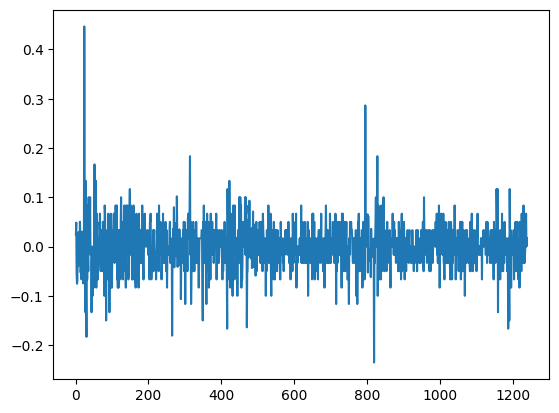

In [13]:
plt.plot(y.diff(1).values)

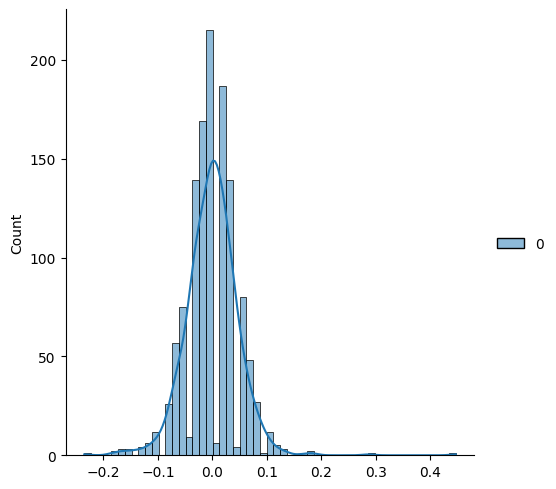

In [14]:
sn.displot(y.diff(1).values, kde=True)

In [15]:
dfs = []
for f in os.listdir(root):
    store = pd.HDFStore(os.path.join(root, f), 'r')
    y = store['y']
    store.close()
    
    dfs.append(y)

In [4]:
df_y = pd.concat(dfs)

In [7]:
df_y['day'] = df_y.index.year.astype(str) + '-' + df_y.index.month.astype(str) + '-' + df_y.index.day.astype(str)
df_y['month'] = df_y.index.year.astype(str) + '-' + df_y.index.month.astype(str)

In [8]:
df_y.month.unique()

array(['2021-4', '2021-5', '2021-6', '2021-7', '2021-8', '2021-9',
       '2021-10', '2021-11', '2021-12', '2022-1', '2022-2', '2022-3',
       '2022-4', '2022-5', '2022-6', '2022-7', '2022-8', '2022-9',
       '2022-10', '2022-11', '2022-12', '2023-1', '2023-2', '2023-3',
       '2023-4'], dtype=object)

In [58]:
for m in df_y.month.unique():
    d = df_y[df_y.month == m]
    fig, ax = plt.subplots(figsize=(24, 10))
    fontsize=18

    plt.rc('xtick', labelsize=fontsize)
    plt.rc('ytick', labelsize=fontsize)

    plt.rcParams['font.size']=10
    ax.tick_params(axis='x', rotation=45)
    sn.violinplot(x = d.day,
                  y = d.y,
                  ax = ax,
                  palette = "GnBu",
                  inner = "box")

    plt.savefig('D:/option/master/diff/15S_15T_%s.png' % m, dpi=600)
    plt.close()


In [11]:
fig, ax = plt.subplots(figsize=(24, 10))
fontsize=18

plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)

plt.rcParams['font.size']=10
ax.tick_params(axis='x', rotation=45)
sn.violinplot(x = df_y.month,
              y = df_y.y,
              ax = ax,
              palette = "GnBu",
              inner = "box",
              bw = .15
             )

plt.savefig('D:/option/master/diff/15S_15T.png', dpi=600)
plt.close()


In [16]:
store = pd.HDFStore('D:/option/SHFE.rb.5S.h5', 'r')
rb = store['rb']
store.close()

In [5]:
rb.last_price.describe().apply(lambda s: '{0:.4f}'.format(s))

count    10864602.0000
mean         4489.9309
std           637.9441
min          3388.0000
25%          3988.0000
50%          4366.0000
75%          5008.0000
max          6204.0000
Name: last_price, dtype: object

In [7]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

In [8]:
scaler = Normalizer()
normalized_data_price = scaler.fit_transform(rb.last_price.to_numpy())

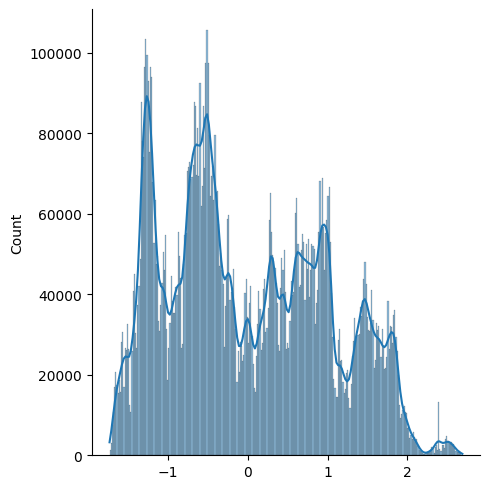

In [10]:
sn.displot(normalized_data_price, kde=True)

In [13]:
d1 = np.log(rb.last_price) - np.log(rb.last_price.shift(1))
d2 = np.log(rb.last_price - rb.last_price.shift(1))

D:\Software\Python\torch\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Software\Python\torch\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [14]:
d1.head(10)

datetime
2021-04-06 09:00:00         NaN
2021-04-06 09:00:01    0.000779
2021-04-06 09:00:02    0.000000
2021-04-06 09:00:03    0.000000
2021-04-06 09:00:04   -0.000389
2021-04-06 09:00:05   -0.000974
2021-04-06 09:00:06   -0.000975
2021-04-06 09:00:07    0.000000
2021-04-06 09:00:08   -0.000390
2021-04-06 09:00:09    0.000000
Name: last_price, dtype: float64

In [14]:
d2.head(10)

datetime
2021-04-06 09:00:00         NaN
2021-04-06 09:00:01    1.386294
2021-04-06 09:00:02        -inf
2021-04-06 09:00:03        -inf
2021-04-06 09:00:04         NaN
2021-04-06 09:00:05         NaN
2021-04-06 09:00:06         NaN
2021-04-06 09:00:07        -inf
2021-04-06 09:00:08         NaN
2021-04-06 09:00:09        -inf
Name: last_price, dtype: float64

In [11]:
%matplotlib qt

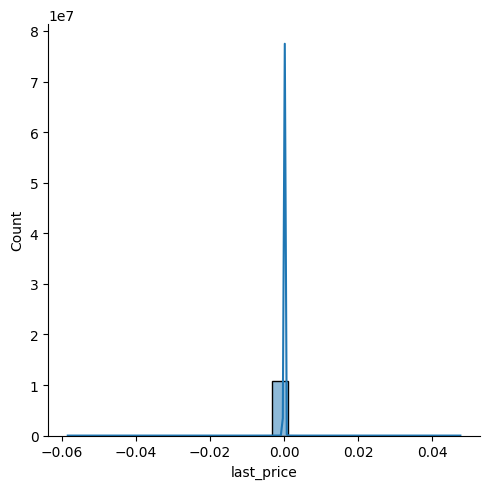

In [10]:
sn.displot(d, kde=True)

In [19]:
dd = 1 / (1 + np.exp(-rb.last_price.diff(1)))

In [22]:
sn.displot(dd, kde=True)

In [28]:
rb.last_price.describe().apply(lambda s: '{0:.4f}'.format(s))

count    10864602.0000
mean         4489.9309
std           637.9441
min          3388.0000
25%          3988.0000
50%          4366.0000
75%          5008.0000
max          6204.0000
Name: last_price, dtype: object

In [17]:
%matplotlib qt

In [22]:
x = np.random.randn(5000)

In [23]:
sn.violinplot(x)

<AxesSubplot:>

In [21]:
x = np.random.randn(3000)

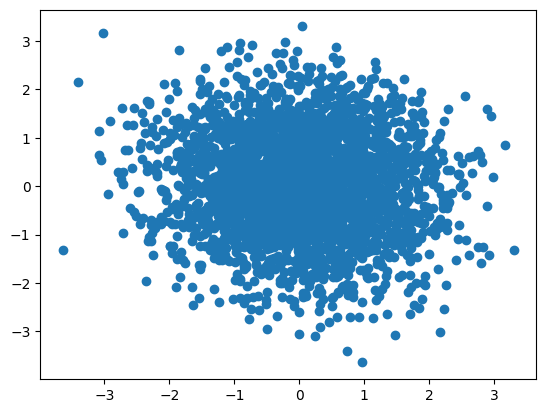

In [23]:
plt.scatter(x, np.roll(x, 1))

In [43]:
store = pd.HDFStore('D:/option/SHFE.rb.1S.h5', 'r')
df = store['rb']
store.close()

In [89]:
d = df.loc['2021-04-06']
# d = df.loc['2021-04-07'].between_time('09:00', '10:15')
# d = df.loc['2021-04-06'].between_time('10:15', '11:30')
# d = df.loc['2021-04-06'].between_time('13:30', '15:00')
# d = df.loc['2021-04-06'].between_time('21:00', '23:00')

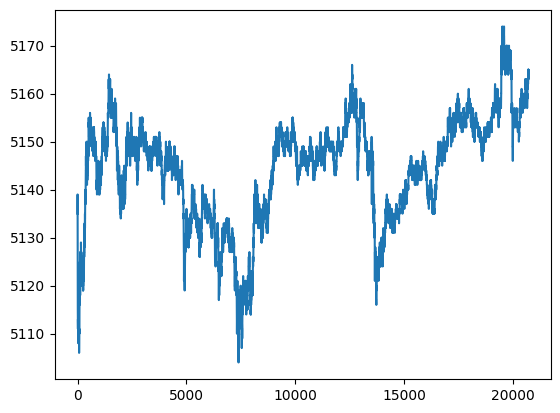

In [92]:
plt.plot(d.last_price.values)

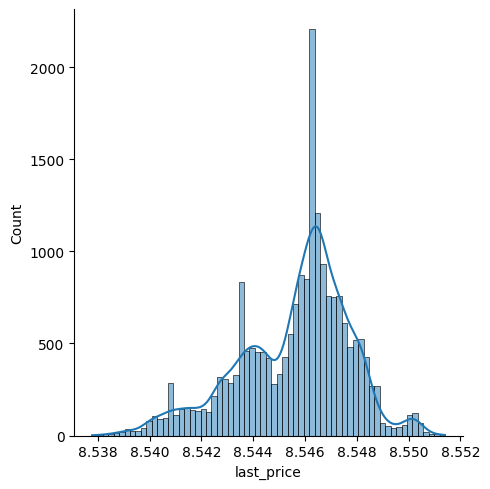

In [93]:
sn.displot(np.log(d.last_price), kde=True)

D:\Software\Python\torch\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


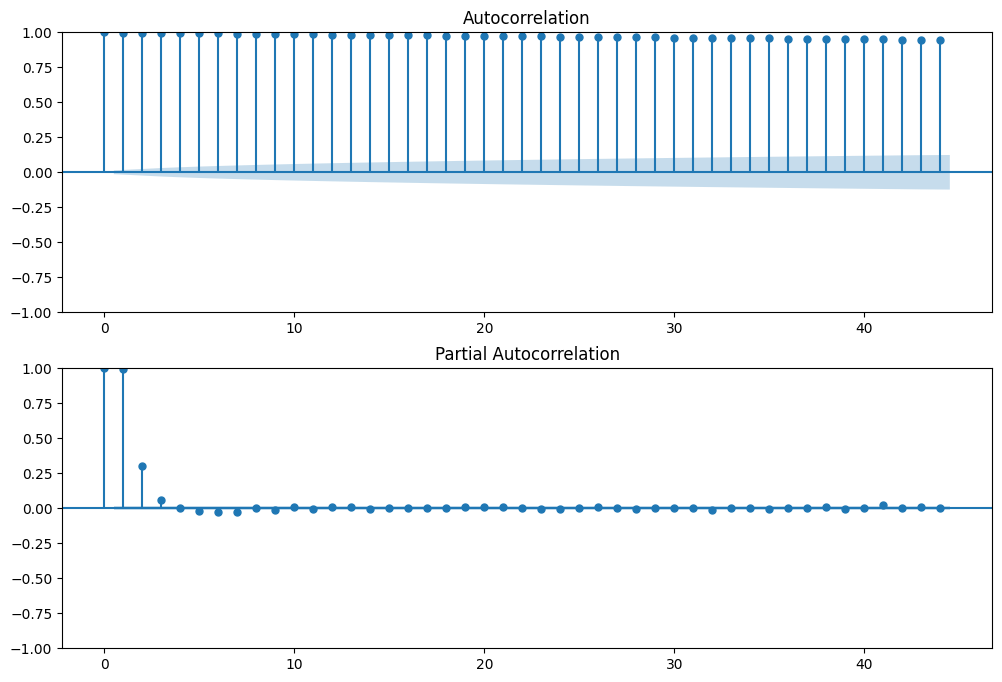

In [94]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
ax = tsaplots.plot_acf(d.last_price, ax=ax1)
ax2 = fig.add_subplot(212)
ax = tsaplots.plot_pacf(d.last_price, ax=ax2)

In [102]:
arima_mod = ARIMA(d.last_price.values, order=(3, 0, 0)).fit()
print(arima_mod.params)

[5.14411540e+03 6.70757560e-01 2.70360325e-01 5.75097294e-02
 5.08392982e-01]


In [103]:
arima_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                20703
Model:                 ARIMA(3, 0, 0)   Log Likelihood              -22376.458
Date:                Tue, 04 Jul 2023   AIC                          44762.917
Time:                        11:01:30   BIC                          44802.607
Sample:                             0   HQIC                         44775.880
                              - 20703                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5144.1154      3.536   1454.658      0.000    5137.184    5151.046
ar.L1          0.6708      0.005    125.681      0.000       0.660       0.681
ar.L2          0.2704      0.007     36.893      0.000       0.256       0.285
ar.L3          0.0575      0.006      9.949      0.000       0.046       0.069
sigma2         0.5084      0.004    131.842      0.000       0.501       0.516
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3029.58
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

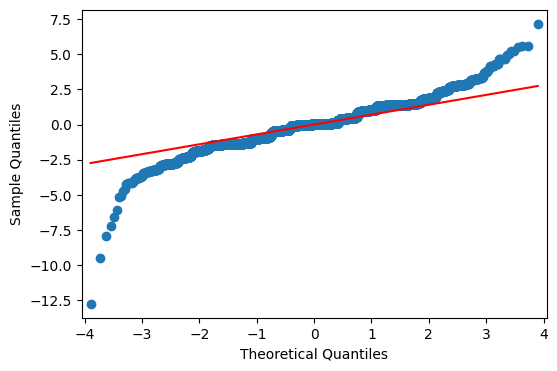

In [97]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
fig = qqplot(arima_mod.resid, line='q', ax=ax, fit=True)

In [100]:
def day_ar(df):
    
    with tqdm.tqdm(np.unique(df.index.date)) as bar:
        for d in bar:
            bar.set_postfix({'date': d})
            ddd = df[df.index.date == d]
            
            arima_mod = ARIMA(ddd.last_price.values, order=(3, 0, 0)).fit()
            
            fig = plt.figure(figsize=(6, 4))
            ax = fig.add_subplot(111)
            fig = qqplot(arima_mod.resid, line='q', ax=ax, fit=True)
            plt.savefig(os.path.join('D:/option/ar', '%s.png' % d))
            plt.close()


In [101]:
day_ar(df)

  2%|▌                       | 13/530 [00:55<35:31,  4.12s/it, date=2021-04-23]D:\Software\Python\torch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Software\Python\torch\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  6%|█▎                      | 30/530 [02:26<49:38,  5.96s/it, date=2021-05-21]D:\Software\Python\torch\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 55%|████████████▋          | 292/530 [22:01<17:57,  4.53s/it, date=2022-06-21]


KeyboardInterrupt: 